In [19]:
from typing import List, Optional, Any
from pydantic import BaseModel
import yaml
import networkx as nx
import matplotlib.pyplot as plt
import json

In [20]:
class Metadata(BaseModel):
    generateName: Optional[str]

class Parameter(BaseModel):
    name: str

class Inputs(BaseModel):
    parameters: List[Parameter]

class Container(BaseModel):
    image: str
    command: List[str]

class TaskParameter(BaseModel):
    name: str
    value: Any

class Arguments(BaseModel):
    parameters: List[TaskParameter]

class Task(BaseModel):
    name: str
    template: str
    depends: Optional[str] = None
    arguments: Optional[Arguments] = None

class Dag(BaseModel):
    tasks: List[Task]

class Template(BaseModel):
    name: str
    inputs: Optional[Inputs] = None
    container: Optional[Container] = None
    dag: Optional[Dag] = None

class Spec(BaseModel):
    entrypoint: str
    templates: List[Template]

class Workflow(BaseModel):
    apiVersion: str
    kind: str
    metadata: Metadata
    spec: Spec

In [21]:
def load_workflow_yaml(file_path: str) -> Workflow:
    with open(file_path, "r", encoding="utf-8") as f:
        content = yaml.safe_load(f)
    return Workflow(**content)

In [22]:
def plot_workflow_dag(workflow: Workflow, dag_template_name: str = None):
    dag_template = None
    for t in workflow.spec.templates:
        if t.dag is not None:
            if dag_template_name is None or t.name == dag_template_name:
                dag_template = t
                break

    tasks = dag_template.dag.tasks
    G = nx.DiGraph()

    for task in tasks:
        G.add_node(task.name)
        if task.depends:
            dependencies = [dep.strip() for dep in task.depends.split("&&")]
            for dep in dependencies:
                G.add_edge(dep, task.name)

    pos = nx.spring_layout(G)
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightgreen",
        node_size=2000,
        font_size=10,
        arrows=True
    )
    plt.title("Workflow DAG")
    plt.show()

{
  "apiVersion": "argoproj.io/v1alpha1",
  "kind": "Workflow",
  "metadata": {
    "generateName": "dag-multiroot-"
  },
  "spec": {
    "entrypoint": "multiroot",
    "templates": [
      {
        "name": "echo",
        "inputs": {
          "parameters": [
            {
              "name": "message"
            }
          ]
        },
        "container": {
          "image": "alpine:3.7",
          "command": [
            "echo",
            "{{inputs.parameters.message}}"
          ]
        },
        "dag": null
      },
      {
        "name": "multiroot",
        "inputs": null,
        "container": null,
        "dag": {
          "tasks": [
            {
              "name": "A",
              "template": "echo",
              "depends": null,
              "arguments": {
                "parameters": [
                  {
                    "name": "message",
                    "value": "A"
                  }
                ]
              }
            },
      

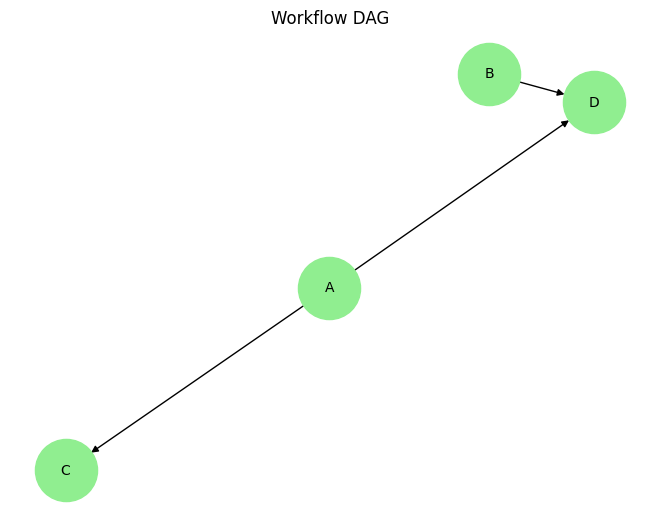

In [23]:
file_path = "workflow.yaml"
workflow = load_workflow_yaml(file_path)

print(json.dumps(workflow.model_dump(), ensure_ascii=False, indent=2))

plot_workflow_dag(workflow)